In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydataset2024/training.csv
/kaggle/input/mydataset2024/test.csv


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# Load training data
train_data_path = '/kaggle/input/mydataset2024/training.csv'
df = pd.read_csv(train_data_path)

# Split the DataFrame into features and target variable
X = df.drop(['DiagPeriodL90D', 'patient_id'], axis=1)  # Assuming 'patient_id' and 'DiagPeriodL90D' are in your df
y = df['DiagPeriodL90D']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns that need to be one-hot encoded
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

# Create the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("Improved Accuracy:", accuracy_score(y_val, y_val_pred))
print("Improved ROC-AUC:", roc_auc_score(y_val, y_val_pred_proba))

# Train the model
#model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

# Load test data
test_data_path = '/kaggle/input/mydataset2024/test.csv'  # Update this path to your test data
test_df = pd.read_csv(test_data_path)

# Make predictions on the test data
test_predictions = model.predict_proba(test_df.drop(['patient_id'], axis=1))[:, 1]

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],  # Ensure test data contains 'patient_id'
    'DiagPeriodL90D': test_predictions
})

# Save the submission file
submission_path = '/kaggle/working/submission.csv'  # Specify your desired submission file path
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")


KeyboardInterrupt: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

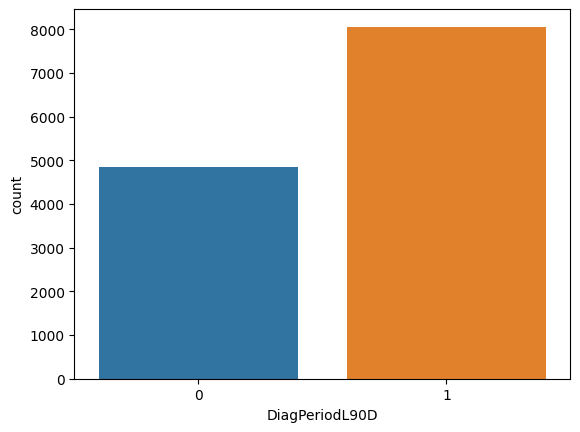

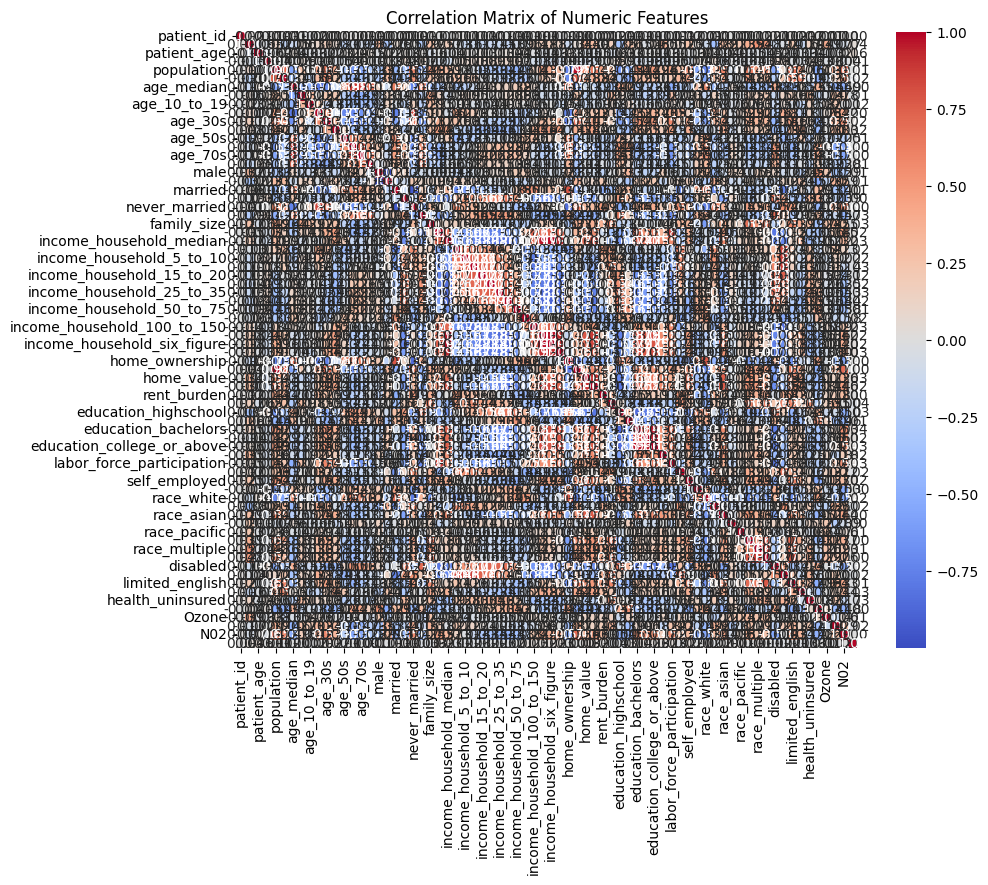

ValueError: A given column is not a column of the dataframe

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_data_path = '/kaggle/input/mydataset2024/training.csv'  # Update this path
df = pd.read_csv(train_data_path)

# EDA
# Basic info
print(df.info())

# Summary statistics for numerical features
print(df.describe())

# Distribution of the target variable
sns.countplot(x='DiagPeriodL90D', data=df)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df contains numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Check if numeric_df is not empty
if not numeric_df.empty:
    # Calculate correlations
    corr_matrix = numeric_df.corr()
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()
else:
    print("No numeric columns available for correlation calculation.")

# Preprocessing
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

# Define preprocessing for numerical columns (impute missing values with median)
numerical_transformer = SimpleImputer(strategy='median')

# Define preprocessing for categorical columns (impute missing values with the most frequent value and apply one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into features and target variable
X = df.drop(['DiagPeriodL90D', 'patient_id'], axis=1)  # Assume 'patient_id' is not a feature
y = df['DiagPeriodL90D']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

# TPOT Model Training
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    random_state=42,
    scoring='accuracy',  # Change scoring method as needed
    n_jobs=-1,
    use_dask=True  # Enable if running in an environment that supports Dask for parallel processing
)

# Fit TPOT with preprocessed data
tpot.fit(preprocessor.fit_transform(X_train), y_train)

# Evaluate the model
print(f"Test accuracy: {tpot.score(preprocessor.transform(X_test), y_test)}")

# Save the TPOT pipeline
tpot.export('tpot_pipeline.py')


In [ ]:
# Assuming TPOT has been trained as shown in the previous example

# Load the test dataset
test_data_path = '/kaggle/input/mydataset2024/test.csv'  # Update this path to where your test data is stored
test_df = pd.read_csv(test_data_path)

# Ensure the test dataset is preprocessed identically to the training dataset
# Note: This step assumes that any necessary preprocessing (not handled automatically by TPOT) 
# has been applied to the test dataset similarly to the training dataset

# Use the trained TPOT model to make predictions on the test data
# TPOT handles the preprocessing steps internally, so we directly predict on raw features
# Ensure to drop 'patient_id' or any non-feature column that was not included in the training
test_features = test_df.drop(['patient_id'], axis=1, errors='ignore')  # 'errors=ignore' allows column absence

# For a classification problem, getting the probability of the positive class (assuming binary classification)
test_predictions_proba = tpot.predict_proba(test_features)[:, 1]  # Adjust index based on your target class

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],  # Assuming 'patient_id' is the identifier column in your test dataset
    'DiagPeriodL90D': test_predictions_proba
})

# Specify your desired submission file path
submission_file_path = '/kaggle/working/submission_tpot.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


In [ ]:
# Assuming you have the true labels for your test dataset in a column named 'DiagPeriodL90D'
# and that you've already loaded the test data into `test_df` as shown previously

# Extract true labels from the test dataset
y_test_true = test_df['DiagPeriodL90D']  # Ensure this matches the name of your target variable column

# Use the trained TPOT model to make predictions for the test dataset
y_test_pred = tpot.predict(test_features)  # test_features prepared as shown in the previous code snippet

# Calculate the accuracy on the test data
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Accuracy on the test data: {test_accuracy}")

# Optionally, calculate additional metrics like ROC-AUC if appropriate
from sklearn.metrics import roc_auc_score

test_predictions_proba = tpot.predict_proba(test_features)[:, 1]  # Assuming binary classification
test_roc_auc = roc_auc_score(y_test_true, test_predictions_proba)
print(f"ROC-AUC on the test data: {test_roc_auc}")
